# Artificial Neural Networks and Deep Learning

---

## Homework 2: Bio.log(y)

### Model 7: U-Net Xception-style model

In [1]:
# IMPORT LIBRARIES and SET SEED
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.saving import register_keras_serializable


# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


## ⏳ Load the Data

In [2]:
# IMPORT DATA
data = np.load("/kaggle/input/mydatasets-baseee/mars_datasets_base.npz")

# Extract the individual arrays
X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]
X_our_test = data["X_our_test"]
y_our_test = data["y_our_test"]
X_test = data["X_test"]

# Print shapes to verify successful loading
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_our_test shape: {X_our_test.shape}")
print(f"y_our_test shape: {y_our_test.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (1503, 64, 128, 1)
y_train shape: (1503, 64, 128)
X_val shape: (501, 64, 128, 1)
y_val shape: (501, 64, 128)
X_our_test shape: (501, 64, 128, 1)
y_our_test shape: (501, 64, 128)
X_test shape: (10022, 64, 128, 1)


## 🛠️ Train and Save the Model

In [3]:
# SET PARAMETERS
input_shape = (64, 128, 1)  
num_classes = len(np.unique(y_train))

# Number of training epochs
epochs = 200
# Batch size for training
batch_size = 32

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input shape:", input_shape)
print("Number of classes:", num_classes)

Epochs: 200
Batch Size: 32
Input shape: (64, 128, 1)
Number of classes: 5


In [4]:
# DEFINE COLOR-SEGMENTATION FUNCTIONS
def create_segmentation_colormap(num_classes):
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    label = np.asarray(label).squeeze()

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [5]:
# DEFINE CUSTOM Mean Intersection Over Union METRIC and VIZCALLBACK
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
          labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, num_classes, frequency=5):
        super().__init__()
        self.image = image
        self.label = label  # Assumiamo che `label` sia già un array NumPy
        self.num_classes = num_classes
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epoche
            pred = self.model.predict(tf.expand_dims(self.image, axis=0), verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.image.squeeze(), cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(self.label, colormap)  # Rimosso `.numpy()`
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [6]:
# DEFINE CUSTOM LOSS FUNCTION
def focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])

    # Exclude the background class
    y_true = y_true[..., 1:]  
    y_pred = y_pred[..., 1:]  

    # Clip predictions
    epsilon = tf.keras.backend.epsilon()
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

    # Focal loss
    cross_entropy = -y_true * tf.math.log(y_pred)
    weights = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weights * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))

def dice_loss(y_true, y_pred, smooth=1e-6):

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=5)

    # Exclude the background class
    y_true = y_true[..., 1:] 
    y_pred = y_pred[..., 1:]  

    # Intersection and union
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2])

    # Dice loss
    dice = 1 - (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def combined_loss(y_true, y_pred, dice_weight=0.5, focal_weight=0.5):
    d_loss = dice_loss(y_true, y_pred)
    f_loss = focal_loss(y_true, y_pred)
    return focal_weight * f_loss + dice_weight * d_loss

In [7]:
from keras import layers
from keras import Input, Model
import keras

def get_model(input_shape=input_shape, num_classes=num_classes, seed=seed):
    if seed:
        keras.utils.set_random_seed(seed)

    inputs = Input(shape=input_shape)  # Grayscale input

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs, name="Mars_Segmentation_Model")
    return model

Model: "Mars_Segmentation_Model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 32, 64,  │       320 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 32, 64,  │         0 │ activation[0]… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ separable_conv2d  │ (None, 32, 64,  │     2,400 │ activation_1[… │   Y   │
│ (SeparableConv2D) │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ separable_con… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ separable_conv2d… │ (None, 32, 64,  │     4,736 │ activation_2[… │   Y   │
│ (SeparableConv2D) │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ separable_con… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 16, 32,  │         0 │ batch_normali… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 16, 32,  │     2,112 │ activation[0]… │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 16, 32,  │         0 │ max_pooling2d… │   -   │
│                   │ 64)             │           │ conv2d_1[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 16, 32,  │         0 │ add[0][0]      │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ separable_conv2d… │ (None, 16, 32,  │     8,896 │ activation_3[… │   Y   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 16, 32,  │       512 │ separable_con… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_4      │ (None, 16, 32,  │         0 │ batch_normali… │   - 

 Total params: 2,058,981 (7.85 MB)

 Trainable params: 2,055,205 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

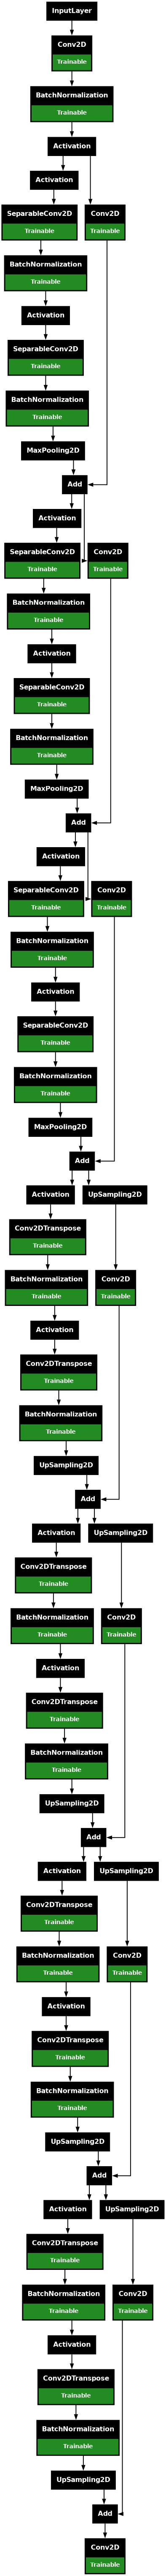

In [8]:
model = get_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [9]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])

model.summary()

Model: "Mars_Segmentation_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 64,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 64,    │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 64,    │          0 │ activation[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 32, 64,    │      2,400 │ activation_1[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 32, 64,    │      4,736 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 16, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 16, 32,    │      2,112 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 16, 32,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 16, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 16, 32,    │      8,896 │ activation_3[0][… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 32,    │        512 │ separable_conv2d… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 16, 32,    │          0 │ batch_normalizat

 Total params: 2,058,981 (7.85 MB)

 Trainable params: 2,055,205 (7.84 MB)

 Non-trainable params: 3,776 (14.75 KB)

In [10]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=20,
    restore_best_weights=True
)

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Select a specific image and mask from the dataset
sample_idx = 42
sample_image = X_train[sample_idx]
sample_mask = y_train[sample_idx]

# Initialize the VizCallback with the selected image and mask
viz_callback = VizCallback(
    image=sample_image,
    label=sample_mask,
    num_classes=num_classes,
    frequency=5
)

Epoch 1/200


I0000 00:00:1734194487.124215      89 service.cc:145] XLA service 0x7a18bc002c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734194487.124267      89 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 5/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.2233 - loss: 1.0444 - mean_iou: 0.1170

I0000 00:00:1734194501.333952      89 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.3563 - loss: 0.6784 - mean_iou: 0.1914

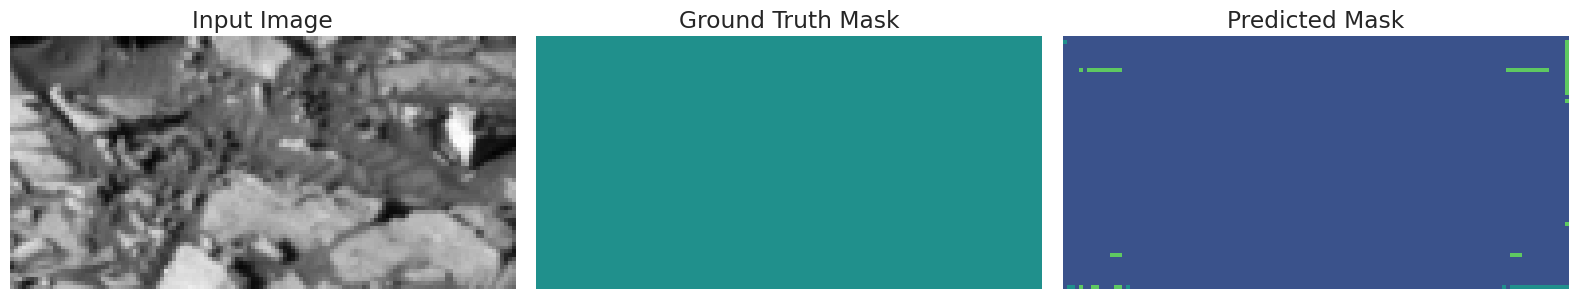

47/47 ━━━━━━━━━━━━━━━━━━━━ 51s 566ms/step - accuracy: 0.3574 - loss: 0.6732 - mean_iou: 0.1921 - val_accuracy: 0.3391 - val_loss: 0.3479 - val_mean_iou: 0.1132 - learning_rate: 0.0010
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4803 - loss: 0.1871 - mean_iou: 0.2907 - val_accuracy: 0.3397 - val_loss: 0.3926 - val_mean_iou: 0.1123 - learning_rate: 0.0010
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5426 - loss: 0.1595 - mean_iou: 0.3402 - val_accuracy: 0.3399 - val_loss: 0.4394 - val_mean_iou: 0.1120 - learning_rate: 0.0010
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5607 - loss: 0.1562 - mean_iou: 0.3592 - val_accuracy: 0.3401 - val_loss: 0.4889 - val_mean_iou: 0.1118 - learning_rate: 0.0010
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.5650 - loss: 0.1557 - mean_iou: 0.3637 - val_accuracy: 0.3401 - val_loss: 0.5289 - val_mean_iou: 0.1117 - learning_rate: 0.0010
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 0

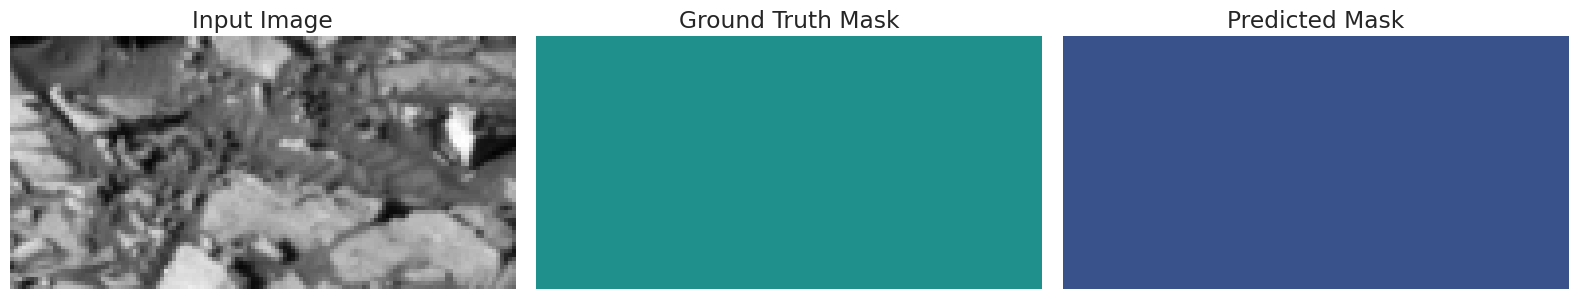

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5805 - loss: 0.1515 - mean_iou: 0.3800 - val_accuracy: 0.3401 - val_loss: 0.5263 - val_mean_iou: 0.1117 - learning_rate: 0.0010
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6098 - loss: 0.1444 - mean_iou: 0.4125 - val_accuracy: 0.3402 - val_loss: 0.5472 - val_mean_iou: 0.1118 - learning_rate: 5.0000e-04
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6241 - loss: 0.1402 - mean_iou: 0.4300 - val_accuracy: 0.3402 - val_loss: 0.5515 - val_mean_iou: 0.1119 - learning_rate: 5.0000e-04
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6371 - loss: 0.1368 - mean_iou: 0.4453 - val_accuracy: 0.3406 - val_loss: 0.5480 - val_mean_iou: 0.1131 - learning_rate: 5.0000e-04
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6503 - loss: 0.1329 - mean_iou: 0.4615 - val_accuracy: 0.3471 - val_loss: 0.5413 - val_mean_iou: 0.1278 - learning_rate: 5.0000e-04
Epoch 11/200
47/47 ━━━━━━

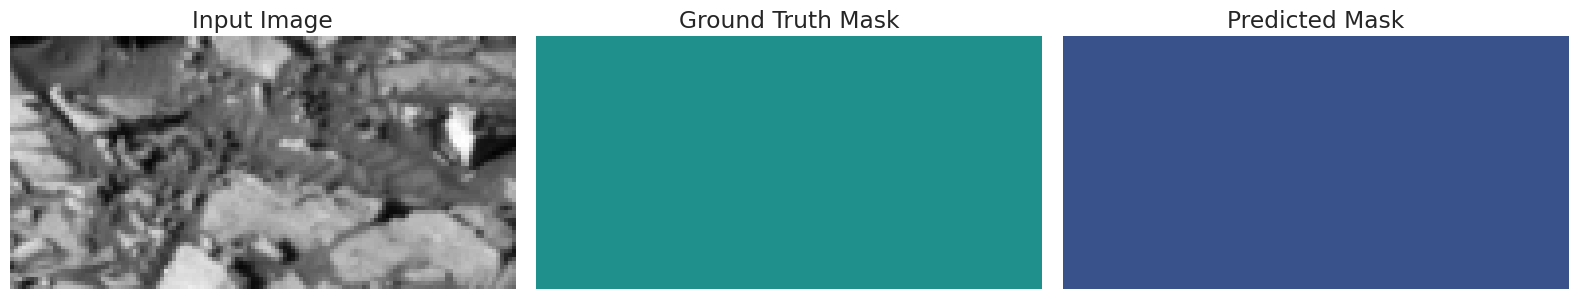

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6689 - loss: 0.1280 - mean_iou: 0.4929 - val_accuracy: 0.3766 - val_loss: 0.5193 - val_mean_iou: 0.1789 - learning_rate: 5.0000e-04
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6774 - loss: 0.1247 - mean_iou: 0.5046 - val_accuracy: 0.4042 - val_loss: 0.5027 - val_mean_iou: 0.2191 - learning_rate: 2.5000e-04
Epoch 13/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6738 - loss: 0.1254 - mean_iou: 0.5002 - val_accuracy: 0.4427 - val_loss: 0.4168 - val_mean_iou: 0.2703 - learning_rate: 2.5000e-04
Epoch 14/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6862 - loss: 0.1219 - mean_iou: 0.5169 - val_accuracy: 0.4930 - val_loss: 0.2927 - val_mean_iou: 0.3356 - learning_rate: 2.5000e-04
Epoch 15/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6930 - loss: 0.1198 - mean_iou: 0.5291 - val_accuracy: 0.5606 - val_loss: 0.2152 - val_mean_iou: 0.4315 - learning_rate: 2.5000e-04
Epoch 16/200
47/47

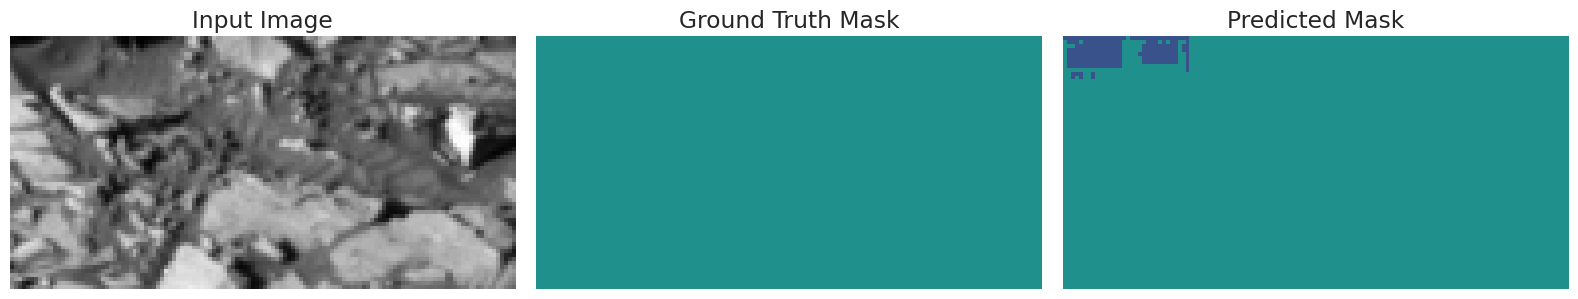

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6884 - loss: 0.1205 - mean_iou: 0.5230 - val_accuracy: 0.5882 - val_loss: 0.1917 - val_mean_iou: 0.4726 - learning_rate: 2.5000e-04
Epoch 17/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6949 - loss: 0.1186 - mean_iou: 0.5293 - val_accuracy: 0.5736 - val_loss: 0.2010 - val_mean_iou: 0.4560 - learning_rate: 2.5000e-04
Epoch 18/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6963 - loss: 0.1191 - mean_iou: 0.5331 - val_accuracy: 0.5660 - val_loss: 0.1994 - val_mean_iou: 0.3563 - learning_rate: 2.5000e-04
Epoch 19/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7032 - loss: 0.1171 - mean_iou: 0.5433 - val_accuracy: 0.5798 - val_loss: 0.1991 - val_mean_iou: 0.4614 - learning_rate: 2.5000e-04
Epoch 20/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7104 - loss: 0.1152 - mean_iou: 0.5536 - val_accuracy: 0.5819 - val_loss: 0.2013 - val_mean_iou: 0.4660 - learning_rate: 2.5000e-04
Epoch 21/200
47/47

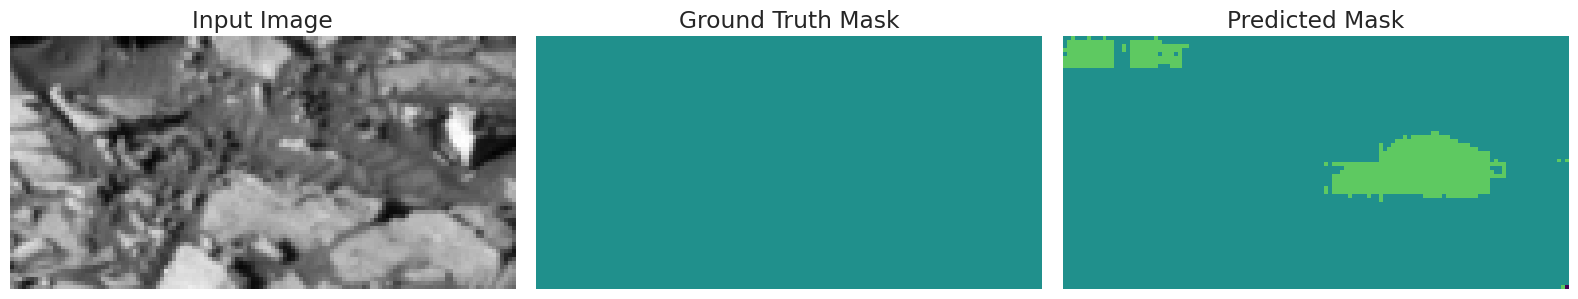

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7158 - loss: 0.1131 - mean_iou: 0.5635 - val_accuracy: 0.5657 - val_loss: 0.2306 - val_mean_iou: 0.3556 - learning_rate: 2.5000e-04
Epoch 22/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7183 - loss: 0.1129 - mean_iou: 0.5672 - val_accuracy: 0.5664 - val_loss: 0.2273 - val_mean_iou: 0.4326 - learning_rate: 1.2500e-04
Epoch 23/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7195 - loss: 0.1131 - mean_iou: 0.5682 - val_accuracy: 0.5914 - val_loss: 0.1976 - val_mean_iou: 0.4730 - learning_rate: 1.2500e-04
Epoch 24/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7266 - loss: 0.1098 - mean_iou: 0.5792 - val_accuracy: 0.5906 - val_loss: 0.2019 - val_mean_iou: 0.4722 - learning_rate: 1.2500e-04
Epoch 25/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7305 - loss: 0.1085 - mean_iou: 0.5854 - val_accuracy: 0.5935 - val_loss: 0.2032 - val_mean_iou: 0.4763 - learning_rate: 1.2500e-04
Epoch 26/200
47/47

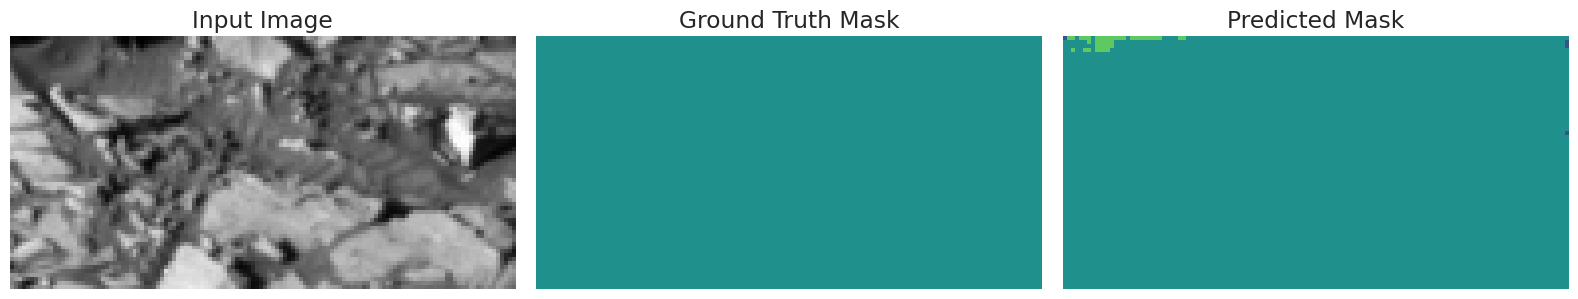

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7301 - loss: 0.1080 - mean_iou: 0.6565 - val_accuracy: 0.6014 - val_loss: 0.2030 - val_mean_iou: 0.4884 - learning_rate: 1.2500e-04
Epoch 27/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7300 - loss: 0.1079 - mean_iou: 0.5849 - val_accuracy: 0.6046 - val_loss: 0.2069 - val_mean_iou: 0.4947 - learning_rate: 6.2500e-05
Epoch 28/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7329 - loss: 0.1074 - mean_iou: 0.5898 - val_accuracy: 0.6056 - val_loss: 0.2103 - val_mean_iou: 0.4965 - learning_rate: 6.2500e-05
Epoch 29/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7330 - loss: 0.1067 - mean_iou: 0.5899 - val_accuracy: 0.6079 - val_loss: 0.2118 - val_mean_iou: 0.5002 - learning_rate: 6.2500e-05
Epoch 30/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7348 - loss: 0.1061 - mean_iou: 0.5930 - val_accuracy: 0.6103 - val_loss: 0.2151 - val_mean_iou: 0.5036 - learning_rate: 6.2500e-05
Epoch 31/200
47/47

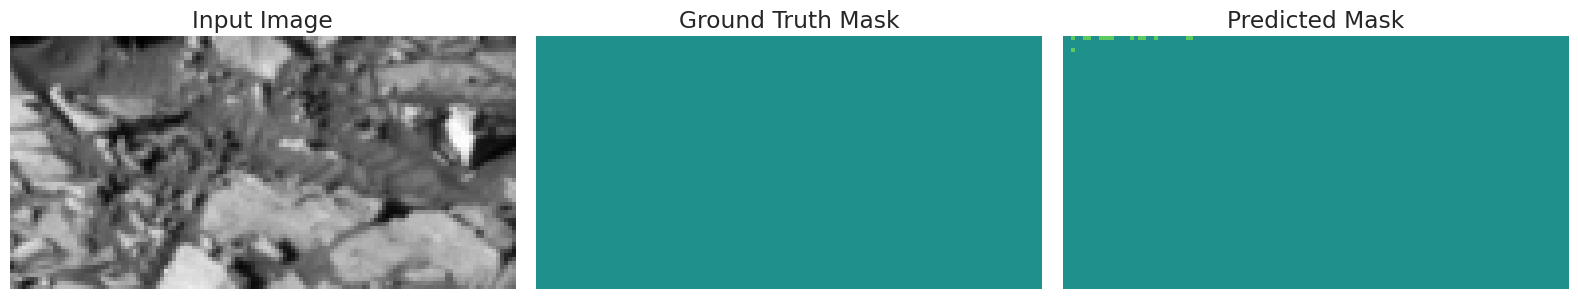

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7371 - loss: 0.1056 - mean_iou: 0.5969 - val_accuracy: 0.6116 - val_loss: 0.2172 - val_mean_iou: 0.5060 - learning_rate: 6.2500e-05
Epoch 32/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7376 - loss: 0.1054 - mean_iou: 0.5980 - val_accuracy: 0.6138 - val_loss: 0.2095 - val_mean_iou: 0.5098 - learning_rate: 3.1250e-05
Epoch 33/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7388 - loss: 0.1050 - mean_iou: 0.5998 - val_accuracy: 0.6130 - val_loss: 0.2100 - val_mean_iou: 0.5084 - learning_rate: 3.1250e-05
Epoch 34/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7405 - loss: 0.1045 - mean_iou: 0.6025 - val_accuracy: 0.6107 - val_loss: 0.2141 - val_mean_iou: 0.5051 - learning_rate: 3.1250e-05
Epoch 35/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7408 - loss: 0.1044 - mean_iou: 0.6030 - val_accuracy: 0.6101 - val_loss: 0.2168 - val_mean_iou: 0.5040 - learning_rate: 3.1250e-05
Epoch 36/200
47/47

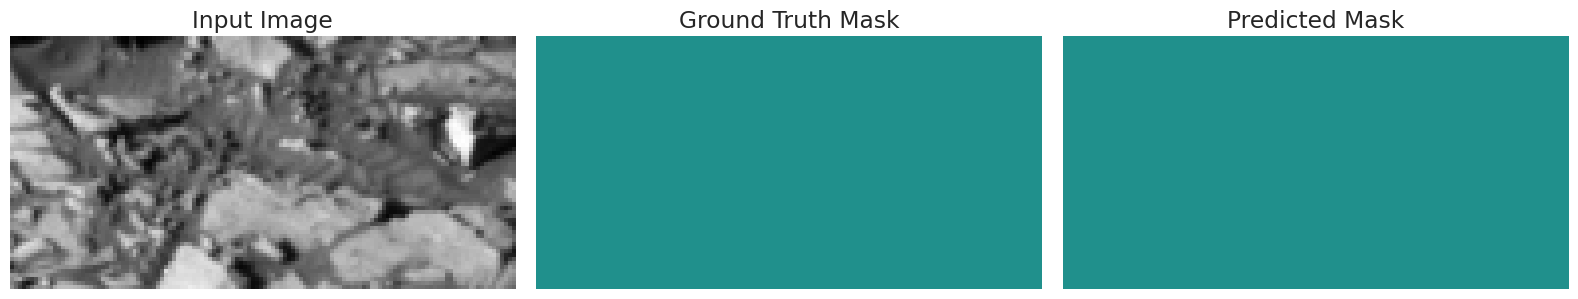

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7412 - loss: 0.1042 - mean_iou: 0.6036 - val_accuracy: 0.6102 - val_loss: 0.2184 - val_mean_iou: 0.5042 - learning_rate: 3.1250e-05
Epoch 37/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7414 - loss: 0.1040 - mean_iou: 0.6041 - val_accuracy: 0.6121 - val_loss: 0.2182 - val_mean_iou: 0.5071 - learning_rate: 1.5625e-05
Epoch 38/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7419 - loss: 0.1039 - mean_iou: 0.6049 - val_accuracy: 0.6120 - val_loss: 0.2197 - val_mean_iou: 0.5070 - learning_rate: 1.5625e-05
Epoch 39/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7420 - loss: 0.1038 - mean_iou: 0.6050 - val_accuracy: 0.6119 - val_loss: 0.2210 - val_mean_iou: 0.5069 - learning_rate: 1.5625e-05
Epoch 40/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7420 - loss: 0.1037 - mean_iou: 0.6051 - val_accuracy: 0.6118 - val_loss: 0.2223 - val_mean_iou: 0.5067 - learning_rate: 1.5625e-05
Epoch 41/200
47/47

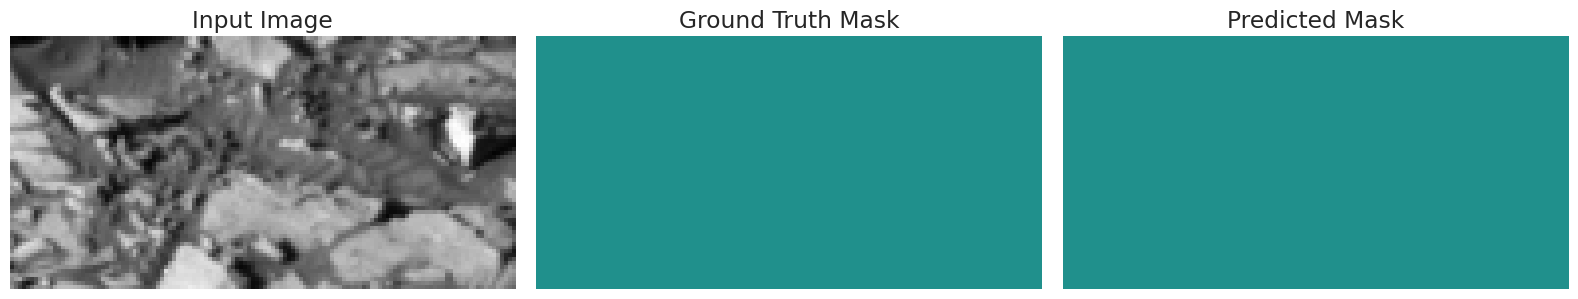

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7421 - loss: 0.1037 - mean_iou: 0.6052 - val_accuracy: 0.6117 - val_loss: 0.2234 - val_mean_iou: 0.5065 - learning_rate: 1.5625e-05
Epoch 42/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7422 - loss: 0.1036 - mean_iou: 0.6054 - val_accuracy: 0.6118 - val_loss: 0.2243 - val_mean_iou: 0.5067 - learning_rate: 7.8125e-06
Epoch 43/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7422 - loss: 0.1036 - mean_iou: 0.6054 - val_accuracy: 0.6117 - val_loss: 0.2252 - val_mean_iou: 0.5065 - learning_rate: 7.8125e-06
Epoch 44/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7423 - loss: 0.1035 - mean_iou: 0.6055 - val_accuracy: 0.6116 - val_loss: 0.2259 - val_mean_iou: 0.5064 - learning_rate: 7.8125e-06
Epoch 45/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7423 - loss: 0.1035 - mean_iou: 0.6055 - val_accuracy: 0.6115 - val_loss: 0.2265 - val_mean_iou: 0.5063 - learning_rate: 7.8125e-06
Epoch 46/200
47/47

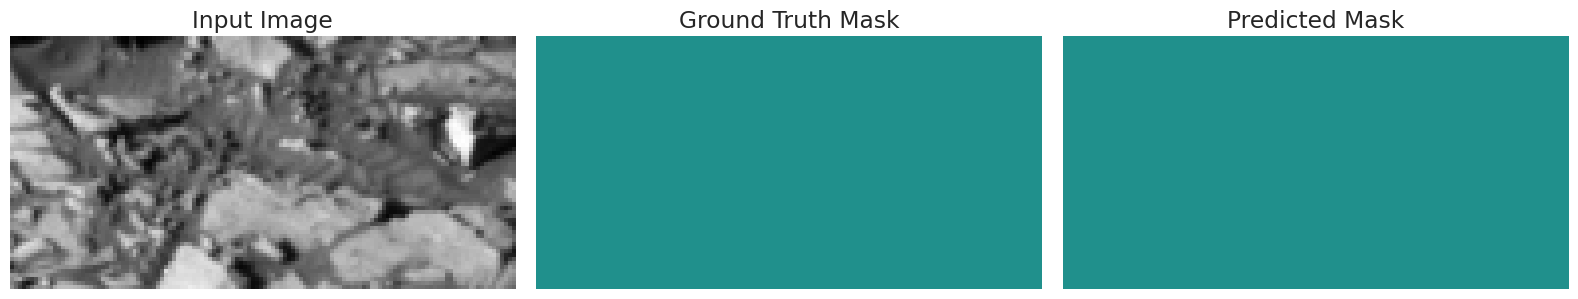

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.7423 - loss: 0.1035 - mean_iou: 0.6056 - val_accuracy: 0.6114 - val_loss: 0.2271 - val_mean_iou: 0.5061 - learning_rate: 7.8125e-06
Epoch 47/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7423 - loss: 0.1034 - mean_iou: 0.6056 - val_accuracy: 0.6114 - val_loss: 0.2277 - val_mean_iou: 0.5061 - learning_rate: 3.9063e-06
Epoch 48/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7424 - loss: 0.1034 - mean_iou: 0.6057 - val_accuracy: 0.6113 - val_loss: 0.2281 - val_mean_iou: 0.5060 - learning_rate: 3.9063e-06
Epoch 49/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7424 - loss: 0.1034 - mean_iou: 0.6057 - val_accuracy: 0.6113 - val_loss: 0.2285 - val_mean_iou: 0.5060 - learning_rate: 3.9063e-06
Epoch 50/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7424 - loss: 0.1034 - mean_iou: 0.6057 - val_accuracy: 0.6112 - val_loss: 0.2289 - val_mean_iou: 0.5059 - learning_rate: 3.9063e-06
Epoch 51/200
47/47

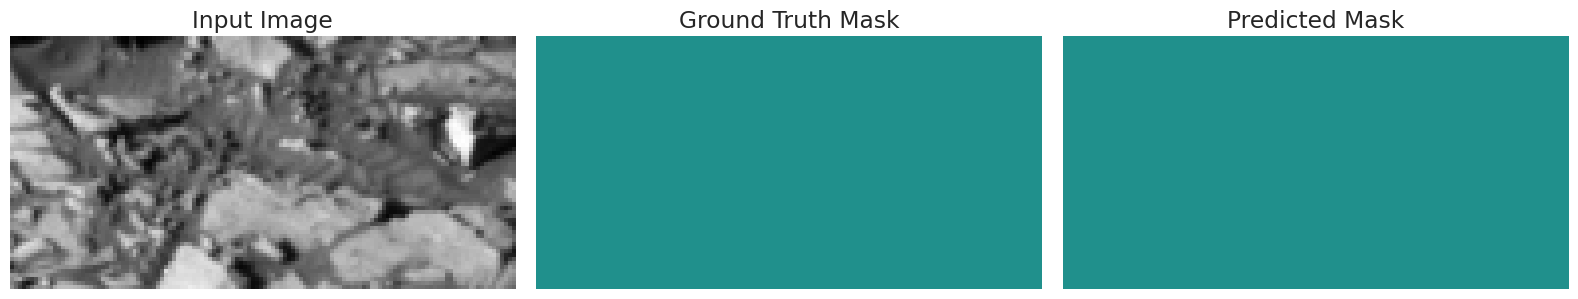

47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7424 - loss: 0.1033 - mean_iou: 0.6057 - val_accuracy: 0.6112 - val_loss: 0.2292 - val_mean_iou: 0.5059 - learning_rate: 3.9063e-06
Epoch 52/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7424 - loss: 0.1033 - mean_iou: 0.6058 - val_accuracy: 0.6112 - val_loss: 0.2295 - val_mean_iou: 0.5058 - learning_rate: 1.9531e-06


In [11]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr, viz_callback],
    verbose=1
).history

In [12]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_Xception_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 50.98%


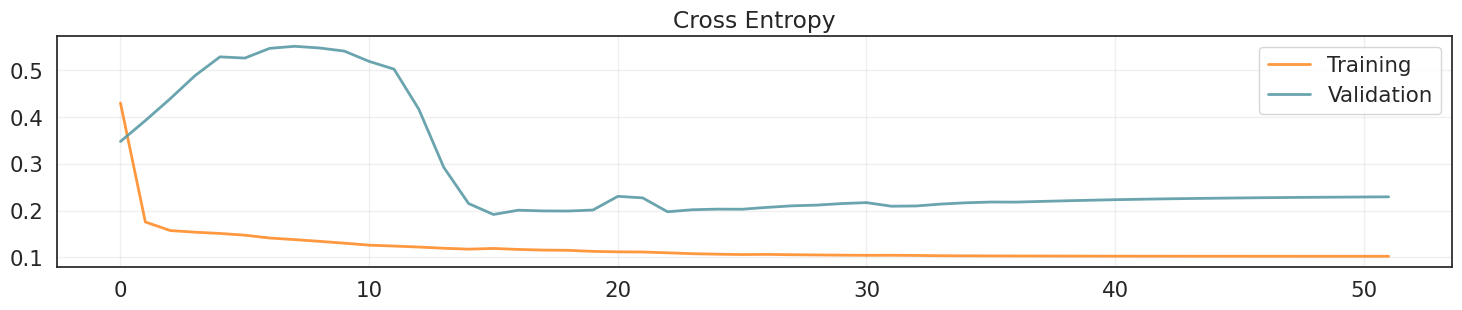

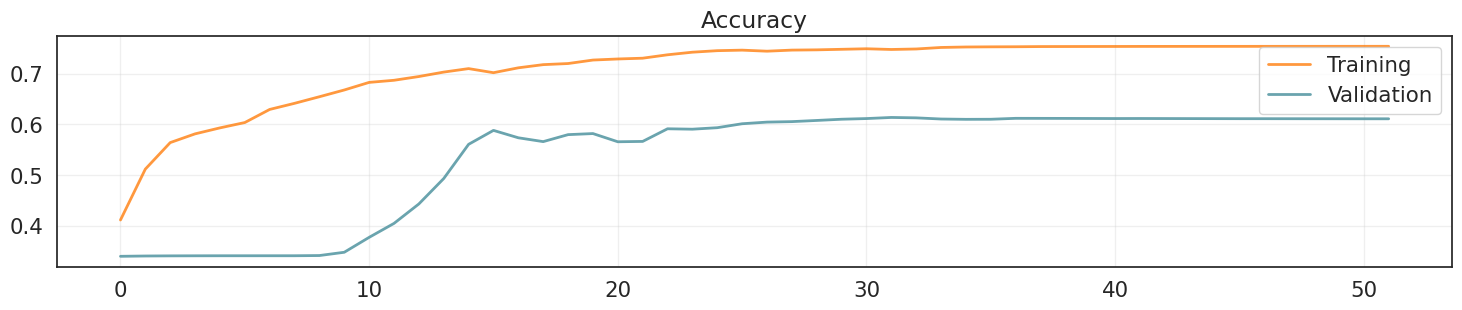

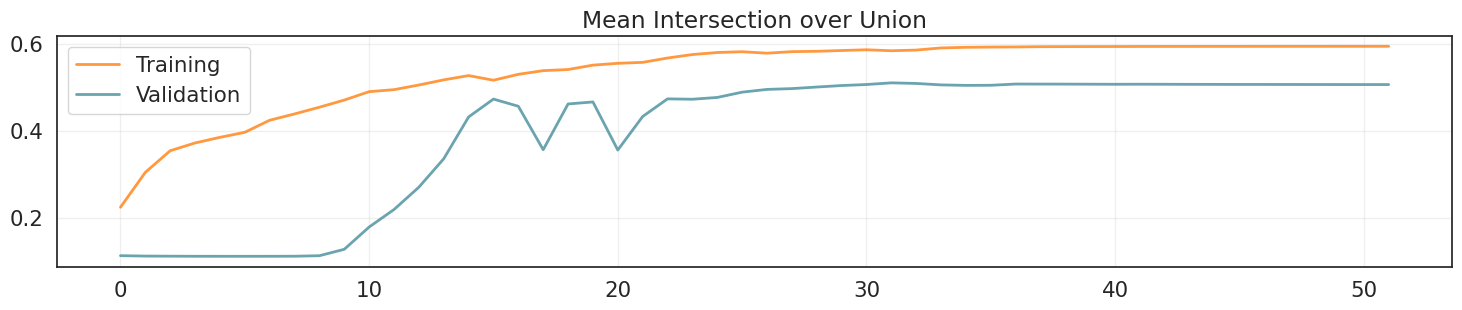

In [13]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [15]:
# path
model_path = "/kaggle/working/UNet_Xception_50.98.keras"

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

Model loaded successfully.


In [16]:
model.compile(optimizer="adam",
              loss=lambda y_true, y_pred: combined_loss(y_true, y_pred, dice_weight=0.2, focal_weight=0.8),
              metrics=["accuracy",
                       MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])])


In [17]:
test_loss, test_accuracy, test_mean_iou = model.evaluate(X_our_test, y_our_test, verbose=1)
print(f"Loss: {test_loss}\nAccuracy: {test_accuracy}\nMean Over Union: {test_mean_iou}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.6121 - loss: 0.1987 - mean_iou: 0.5307
Loss: 0.19973838329315186
Accuracy: 0.6199188828468323
Mean Over Union: 0.5317487716674805


In [19]:
def calculate_class_iou(y_true, y_pred, num_classes):
    class_iou = {}

    for class_idx in range(num_classes):
        # Crea una maschera binaria per la classe
        true_mask = (y_true == class_idx).astype(int)
        pred_mask = (y_pred == class_idx).astype(int)

        # Calcola l'intersezione e l'unione
        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        # Calcola IoU, evitando la divisione per zero
        iou = intersection / union if union > 0 else 0.0
        class_iou[class_idx] = iou

    return class_iou

In [20]:
# Compute the prediction
y_pred = model.predict(X_our_test, batch_size=10)
y_pred_labels = tf.math.argmax(y_pred, axis=-1).numpy()

# Compute IoU per class
iou_per_class = calculate_class_iou(y_our_test, y_pred_labels, num_classes)

# Print the results
for class_idx, iou in iou_per_class.items():
    print(f"Class {class_idx}: IoU = {round(iou, 4)}")

51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step
Class 0: IoU = 0.0
Class 1: IoU = 0.6188
Class 2: IoU = 0.4916
Class 3: IoU = 0.5266
Class 4: IoU = 0.0


In [21]:
def calculate_metrics_per_class(y_true, y_pred, num_classes):
    metrics = {}

    for class_idx in range(num_classes):
        # Create binary masks for the current class
        true_binary = (y_true == class_idx).flatten()
        pred_binary = (y_pred == class_idx).flatten()

        # Compute precision, recall, and F1-score
        precision = precision_score(true_binary, pred_binary, zero_division=0)
        recall = recall_score(true_binary, pred_binary, zero_division=0)
        f1 = f1_score(true_binary, pred_binary, zero_division=0)

        # Store the metrics for the current class
        metrics[class_idx] = {
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }

    return metrics

In [22]:
# Compute metrics for each class
metrics_per_class = calculate_metrics_per_class(y_our_test, y_pred_labels, num_classes)

# Print the results for each class
for class_idx, metrics in metrics_per_class.items():
    print(f"Class {class_idx}:")
    print(f"  Precision = {round(metrics['Precision'], 4)}")
    print(f"  Recall = {round(metrics['Recall'], 4)}")
    print(f"  F1-score = {round(metrics['F1-score'], 4)}")

Class 0:
  Precision = 1.0
  Recall = 0.0
  F1-score = 0.0
Class 1:
  Precision = 0.7071
  Recall = 0.8321
  F1-score = 0.7645
Class 2:
  Precision = 0.5418
  Recall = 0.8414
  F1-score = 0.6592
Class 3:
  Precision = 0.5941
  Recall = 0.8226
  F1-score = 0.6899
Class 4:
  Precision = 0.0
  Recall = 0.0
  F1-score = 0.0


## 📊 Prepare Your Submission


In [ ]:
# Percorso del file del modello
model_path = "/kaggle/working/UNet_Xception_50.98.kerass"

# Carica il modello
model = tf.keras.models.load_model(model_path, compile=False)
print("Model loaded successfully.")

In [23]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions shape: (10022, 64, 128)


In [24]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [25]:
# Create and save the CSV submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)  # Convert predictions to DataFrame
submission_df.to_csv(f"/kaggle/working/{submission_filename}", index=False)

print(f"Submission file saved: {submission_filename}")

Submission file saved: submission_UNet_Xception_50.98.csv
